라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import *
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.losses import Huber

trend_name = 'model/Aqua_all_trend30'
seasonal_name = 'model/Aqua_all_seasonal30'

데이터셋 설정

In [2]:
japonica_training = pd.DataFrame()
japonica_validation = pd.DataFrame()
for i in range(5):
    tank = i + 1
    japonica_training_food_supply_tb = pd.read_csv("dataset/japonica_training_food_supply_tb.csv")
    japonica_training_sensor_val_tb = pd.read_csv("dataset/japonica_training_sensor_val_tb.csv")
    japonica_validation_food_supply_tb = pd.read_csv("dataset/japonica_validation_food_supply_tb.csv")
    japonica_validation_sensor_val_tb = pd.read_csv("dataset/japonica_validation_sensor_val_tb.csv")
    japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['tank_id']==tank]
    japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['tank_id']==tank]
    japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
    japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]
    japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
    japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
    japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
    japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
    japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
    japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
    japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]
    japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
    japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
    japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
    japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
    japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
    japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
    japonica_training_sensor_val_tb['date'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt']).dt.date
    japonica_training_food_supply_tb['date'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt']).dt.date
    common_dates = japonica_training_sensor_val_tb['date'].isin(japonica_training_food_supply_tb['date'])
    japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[common_dates]
    japonica_training_sensor_val_tb = japonica_training_sensor_val_tb.drop('date', axis=1)
    japonica_validation_sensor_val_tb['date'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt']).dt.date
    japonica_validation_food_supply_tb['date'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt']).dt.date
    common_dates = japonica_validation_sensor_val_tb['date'].isin(japonica_validation_food_supply_tb['date'])
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[common_dates]
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.drop('date', axis=1)
    japonica_training_sensor_val_tb.set_index('mea_dt', inplace=True)
    japonica_training_sensor_val_tb = japonica_training_sensor_val_tb.resample('30min').mean()
    japonica_training_sensor_val_tb = japonica_training_sensor_val_tb.reset_index()
    japonica_training_sensor_val_tb = japonica_training_sensor_val_tb.dropna()
    japonica_validation_sensor_val_tb.set_index('mea_dt', inplace=True)
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.resample('30min').mean()
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.reset_index()
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.dropna()
    training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
    validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()
    to_delete = training_counts[training_counts != 48].index
    japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
    to_delete = validation_counts[validation_counts != 48].index
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
    japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
    japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
    japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
    japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
    japonica_training_features = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
    japonica_validation_features = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
    japonica_training_features['mea_dt'] = pd.to_datetime(japonica_training_features['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
    japonica_validation_features['mea_dt'] = pd.to_datetime(japonica_validation_features['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
    feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
    japonica_training_features = japonica_training_features[feature_origin]
    japonica_validation_features = japonica_validation_features[feature_origin]
    japonica_training_features = japonica_training_features.fillna(0)
    japonica_validation_features = japonica_validation_features.fillna(0)
    japonica_training_features.set_index('mea_dt', inplace=True)
    japonica_validation_features.set_index('mea_dt', inplace=True)
    japonica_training_data = japonica_training_features.sort_index()
    japonica_validation_data = japonica_validation_features.sort_index()
    japonica_training_data = japonica_training_data.reset_index()
    japonica_validation_data = japonica_validation_data.reset_index()
    japonica_training_data = japonica_training_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'feed_quantity', 'water_quantity']]
    japonica_validation_data = japonica_validation_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'feed_quantity', 'water_quantity']]
    japonica_training = pd.concat([japonica_training, japonica_training_data])
    japonica_validation = pd.concat([japonica_validation, japonica_validation_data])
    japonica_training.reset_index(drop=True, inplace=True)
    japonica_validation.reset_index(drop=True, inplace=True)

In [3]:
japonica_training_X = japonica_training[['do_mg','do_temp', 'ph', 'orp', 'co2_mg','feed_quantity', 'water_quantity']]
japonica_training_y = japonica_training[['do_mg']]
japonica_validation_X = japonica_validation[['do_mg','do_temp', 'ph', 'orp', 'co2_mg','feed_quantity', 'water_quantity']]
japonica_validation_y = japonica_validation[['do_mg']]

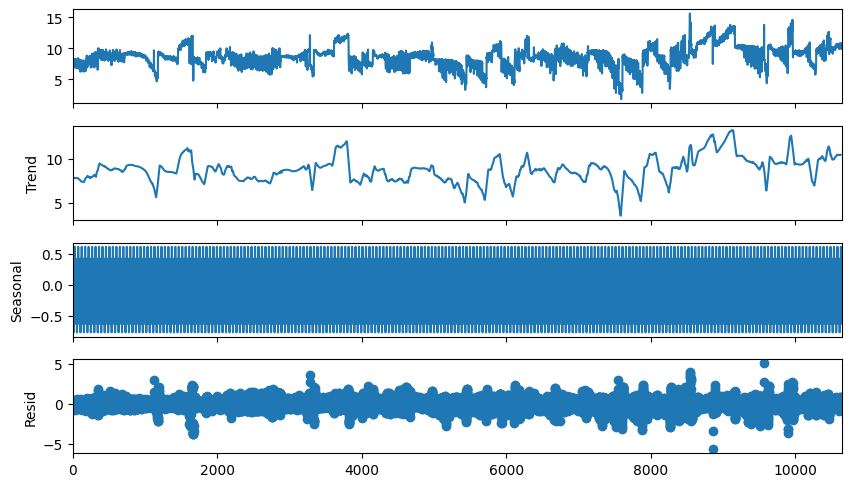

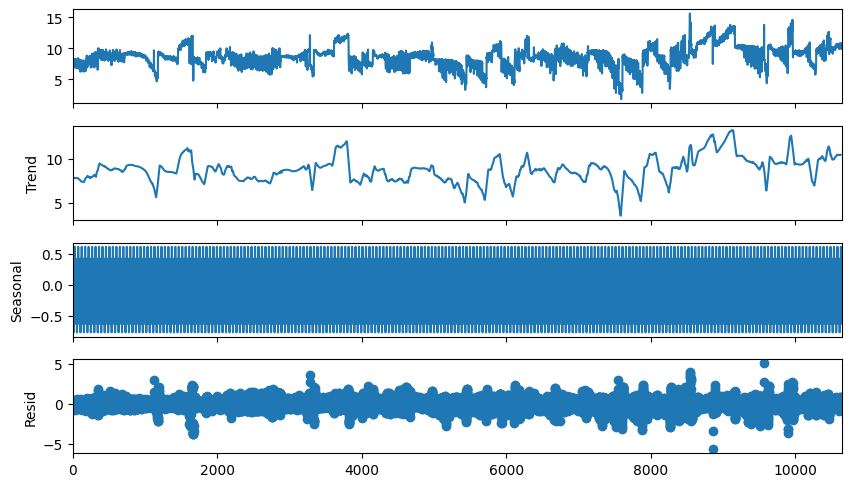

In [4]:
dec = seasonal_decompose(japonica_training_y, model='additive', period=48)
fig = dec.plot()
fig.set_size_inches(9, 5)
japonica_training_y_trend = pd.DataFrame(dec.trend)
japonica_training_y_seasonal = pd.DataFrame(dec.seasonal)
japonica_training_y_resid = pd.DataFrame(dec.resid)
dec = seasonal_decompose(japonica_validation_y, model='additive', period=48)
fig = dec.plot()
fig.set_size_inches(9, 5)
japonica_validation_y_trend = pd.DataFrame(dec.trend)
japonica_validation_y_seasonal = pd.DataFrame(dec.seasonal)
japonica_validation_y_resid = pd.DataFrame(dec.resid)

In [5]:
japonica_training_X = japonica_training_X.iloc[48:-48]
japonica_training_y_trend = japonica_training_y_trend.iloc[48:-48]
japonica_training_y_seasonal = japonica_training_y_seasonal.iloc[48:-48]
japonica_training_y_resid = japonica_training_y_resid.iloc[48:-48]
japonica_validation_X = japonica_validation_X.iloc[48:-48]
japonica_validation_y_trend = japonica_validation_y_trend.iloc[48:-48]
japonica_validation_y_seasonal = japonica_validation_y_seasonal.iloc[48:-48]
japonica_validation_y_resid = japonica_validation_y_resid.iloc[48:-48]

In [6]:
japonica_training_y_trend['trend'] = japonica_training_y_trend['trend']
japonica_validation_y_trend['trend'] = japonica_validation_y_trend['trend']
japonica_training_y_seasonal['seasonal'] = japonica_training_y_seasonal['seasonal'] + japonica_training_y_resid['resid']
japonica_validation_y_seasonal['seasonal'] = japonica_validation_y_seasonal['seasonal'] + japonica_validation_y_resid['resid']

In [7]:
japonica_training_trend_X = japonica_training_X[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg']]
japonica_training_seasonal_X = japonica_training_X[['feed_quantity', 'water_quantity']]
japonica_training_resid_X = japonica_training_X[['do_mg']]
japonica_validation_trend_X = japonica_validation_X[['do_mg', 'do_temp', 'ph', 'orp', 'co2_mg']]
japonica_validation_seasonal_X = japonica_validation_X[['feed_quantity', 'water_quantity']]
japonica_validation_resid_X = japonica_validation_X[['do_mg']]

In [8]:
japonica_training_trend_X = japonica_training_trend_X.iloc[:-6]
japonica_training_resid_X = japonica_training_resid_X.iloc[:-6]
japonica_validation_trend_X = japonica_validation_trend_X.iloc[:-6]
japonica_validation_resid_X = japonica_validation_resid_X.iloc[:-6]
japonica_training_y_trend = japonica_training_y_trend.iloc[6:]
japonica_training_y_resid = japonica_training_y_resid.iloc[6:]
japonica_validation_y_trend = japonica_validation_y_trend.iloc[6:]
japonica_validation_y_resid = japonica_validation_y_resid.iloc[6:]
japonica_training_seasonal_X = japonica_training_seasonal_X.iloc[6:]
japonica_validation_seasonal_X = japonica_validation_seasonal_X.iloc[6:]
japonica_training_y_seasonal = japonica_training_y_seasonal.iloc[6:]
japonica_validation_y_seasonal = japonica_validation_y_seasonal.iloc[6:]
japonica_training_seasonal_X.reset_index(drop=True, inplace=True)
japonica_training_resid_X.reset_index(drop=True, inplace=True)
japonica_training_seasonal_X = pd.concat([japonica_training_seasonal_X, japonica_training_resid_X], axis=1)
japonica_validation_seasonal_X.reset_index(drop=True, inplace=True)
japonica_validation_resid_X.reset_index(drop=True, inplace=True)
japonica_validation_seasonal_X = pd.concat([japonica_validation_seasonal_X, japonica_validation_resid_X], axis=1)

In [9]:
japonica_training_trend_X_chunks = []
japonica_training_seasonal_X_chunks = []
japonica_training_features_y_trend_chunks = []
japonica_training_features_y_seasonal_chunks = []
japonica_validation_trend_X_chunks = []
japonica_validation_seasonal_X_chunks = []
japonica_validation_features_y_trend_chunks = []
japonica_validation_features_y_seasonal_chunks = []
for i in range(0, len(japonica_training_trend_X) - 5):
    japonica_training_trend_X_chunks.append(np.array(japonica_training_trend_X.iloc[i:i+6].values, dtype=np.float64))
japonica_training_trend_X_chunks = np.array(japonica_training_trend_X_chunks, dtype=np.float64)
for i in range(0, len(japonica_training_seasonal_X) - 5):
    japonica_training_seasonal_X_chunks.append(np.array(japonica_training_seasonal_X.iloc[i:i+6].values, dtype=np.float64))
japonica_training_seasonal_X_chunks = np.array(japonica_training_seasonal_X_chunks, dtype=np.float64)
for i in range(0, len(japonica_training_y_trend) - 5):
    japonica_training_features_y_trend_chunks.append(np.array(japonica_training_y_trend.iloc[i:i+6].values, dtype=np.float64))
japonica_training_features_y_trend_chunks = np.array(japonica_training_features_y_trend_chunks, dtype=np.float64)
for i in range(0, len(japonica_training_y_seasonal) - 5):
    japonica_training_features_y_seasonal_chunks.append(np.array(japonica_training_y_seasonal.iloc[i:i+6].values, dtype=np.float64))
japonica_training_features_y_seasonal_chunks = np.array(japonica_training_features_y_seasonal_chunks, dtype=np.float64)
for i in range(0, len(japonica_validation_trend_X) - 5):
    japonica_validation_trend_X_chunks.append(np.array(japonica_validation_trend_X.iloc[i:i+6].values, dtype=np.float64))
japonica_validation_trend_X_chunks = np.array(japonica_validation_trend_X_chunks, dtype=np.float64)
for i in range(0, len(japonica_validation_seasonal_X) - 5):
    japonica_validation_seasonal_X_chunks.append(np.array(japonica_validation_seasonal_X.iloc[i:i+6].values, dtype=np.float64))
japonica_validation_seasonal_X_chunks = np.array(japonica_validation_seasonal_X_chunks, dtype=np.float64)
for i in range(0, len(japonica_validation_y_trend) - 5):
    japonica_validation_features_y_trend_chunks.append(np.array(japonica_validation_y_trend.iloc[i:i+6].values, dtype=np.float64))
japonica_validation_features_y_trend_chunks = np.array(japonica_validation_features_y_trend_chunks, dtype=np.float64)
for i in range(0, len(japonica_validation_y_seasonal) - 5):
    japonica_validation_features_y_seasonal_chunks.append(np.array(japonica_validation_y_seasonal.iloc[i:i+6].values, dtype=np.float64))
japonica_validation_features_y_seasonal_chunks = np.array(japonica_validation_features_y_seasonal_chunks, dtype=np.float64)

In [13]:
huber_loss = Huber(delta=1.0)
model = Sequential()
model.add(LSTM(128, input_shape=(6, 5), return_sequences=True, kernel_initializer='glorot_uniform'))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(6, activation='linear'))
model.summary()
model.compile(optimizer='adam', loss=huber_loss, metrics=['mse', 'mae'])
checkpoint = ModelCheckpoint(trend_name + '_best.keras', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
hist = model.fit(japonica_training_trend_X_chunks, japonica_training_features_y_trend_chunks, epochs = 10000, batch_size = 32, validation_data=(japonica_validation_trend_X_chunks, japonica_validation_features_y_trend_chunks), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(trend_name+'.keras')

c:\Users\rladn\anaconda3\envs\do\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 128)         │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 6, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,630 (510.27 KB)

 Trainable params: 130,630 (510.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 3.8682 - mae: 4.3427 - mse: 26.8987 - val_loss: 0.6697 - val_mae: 1.0551 - val_mse: 1.9782 - learning_rate: 0.0010
Epoch 2/10000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.6557 - mae: 1.0443 - mse: 1.9302 - val_loss: 0.6680 - val_mae: 1.0498 - val_mse: 1.9635 - learning_rate: 0.0010
Epoch 3/10000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.6158 - mae: 1.0009 - mse: 1.7931 - val_loss: 0.3435 - val_mae: 0.6764 - val_mse: 0.8509 - learning_rate: 0.0010
Epoch 4/10000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2761 - mae: 0.5938 - mse: 0.6637 - val_loss: 0.2310 - val_mae: 0.5472 - val_mse: 0.5156 - learning_rate: 0.0010
Epoch 5/10000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2190 - mae: 0.5159 - mse: 0.4991 - val_loss: 0.2729 - val_mae: 0.5926 - val_mse: 0.6298 - learning_rate: 0.0010
Epoch 6/10000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1960 - mae: 0.4857 - mse: 0.4368 - val_loss: 0.

In [14]:
model = Sequential()
model.add(LSTM(128, input_shape=(6, 3), return_sequences=True, kernel_initializer='glorot_uniform'))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(6, activation='linear'))
model.summary()
model.compile(optimizer='adam', loss=huber_loss, metrics=['mse','mae'])
checkpoint = ModelCheckpoint(seasonal_name + '_best.keras', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
hist = model.fit(japonica_training_seasonal_X_chunks, japonica_training_features_y_seasonal_chunks, epochs = 1000, batch_size = 32, validation_data=(japonica_validation_seasonal_X_chunks, japonica_validation_features_y_seasonal_chunks), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(seasonal_name+'.keras')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 6, 128)         │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 6, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,606 (506.27 KB)

 Trainable params: 129,606 (506.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.2241 - mae: 0.5105 - mse: 0.5137 - val_loss: 0.2182 - val_mae: 0.5110 - val_mse: 0.4963 - learning_rate: 0.0010
Epoch 2/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2000 - mae: 0.4831 - mse: 0.4572 - val_loss: 0.1957 - val_mae: 0.4940 - val_mse: 0.4393 - learning_rate: 0.0010
Epoch 3/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1731 - mae: 0.4480 - mse: 0.3849 - val_loss: 0.1671 - val_mae: 0.4433 - val_mse: 0.3750 - learning_rate: 0.0010
Epoch 4/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1614 - mae: 0.4302 - mse: 0.3608 - val_loss: 0.1583 - val_mae: 0.4193 - val_mse: 0.3551 - learning_rate: 0.0010
Epoch 5/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1599 - mae: 0.4268 - mse: 0.3581 - val_loss: 0.1533 - val_mae: 0.4171 - val_mse: 0.3428 - learning_rate: 0.0010
Epoch 6/1000
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1499 - mae: 0.4079 - mse: 0.3341 - val_loss: 0.1596 -